### Sentiment Analysis
Using VADER, AFINN and NRC Lexicons

In [213]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from afinn import Afinn
from nrclex import NRCLex

nltk.download('vader_lexicon')
nltk.download('punkt')  # if you haven't downloaded this nltk corpus before
import spacy
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path
import string
sns.set()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/carlomarx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/carlomarx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [181]:
nlp = spacy.load("en_core_web_sm")
# Create list of punctuation marks
punctuations = string.punctuation

# Create list of stopwords from spaCy
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Remove URLs
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

def remove_handles(tweet):
    return re.sub(r'@\w+', '', tweet)

# Creat tokenizer function
def spacy_tokenizer(sentence):
    sentence = sentence.encode("ascii", errors="ignore").decode()

    tokens = nlp(sentence)
    # Remove links
    tokens = [remove_urls(word) for word in tokens]
    #tokens = [remove_handles(word) for word in tokens]

    # Lemmatize each token and convert each token into lowercase
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "PROPN" else word.lower_ for word in tokens]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    
    # Remove links
    tokens = [remove_urls(word) for word in tokens]
    tokens = [remove_handles(word) for word in tokens]
    
    return " ".join(tokens)


In [227]:
### Load the user data
dirpath = Path("data/day2/")
user = pd.read_csv(dirpath / "user.csv")
user = user.rename(columns={"user.screen_name.anon": "user_id"})
user = user[user["user.followers_count"] > 100]
user_list = user["user_id"].unique().tolist()
np.random.seed(42)
user_list = np.random.choice(user_list, 1000, replace=False)

In [228]:
# Load the tweet data
tweet = pd.read_csv(dirpath / "tl1_anon.csv", sep=";", index_col=0)
tweet = tweet.rename(columns={"screenName.anon": "user_id"})
tweet_small = tweet[tweet["user_id"].isin(user_list)]
tweet_small = tweet_small[["user_id", "text"]]
tweet_small = tweet_small.drop_duplicates(subset=["text"])


In [229]:
# Tokenize tweets
tweet_small["text"] = tweet_small["text"].apply(spacy_tokenizer)

In [230]:
# Filter based on the length of the tweet
tweet_small["length"] = tweet_small["text"].apply(lambda x: len(x))
tweet_small["words"] = tweet_small["text"].apply(lambda x: len(x.split(" ")))
ts = tweet_small[(tweet_small["length"] > 0) & (tweet_small["words"] > 2)]

In [231]:
sia_scorer = SentimentIntensityAnalyzer()
afinn_scorer = Afinn()

In [232]:
ts["vader"] = ts["text"].apply(lambda x: sia_scorer.polarity_scores(x)["compound"])
ts["vader"] = (ts["vader"] - ts["vader"].mean()) / ts["vader"].std()
ts["afinn"] = ts["text"].apply(lambda x: afinn_scorer.score(x))
ts["afinn"] = (ts["afinn"] - ts["afinn"].mean()) / ts["afinn"].std()
ts["top_emotion"] = ts["text"].apply(lambda x: NRCLex(x).top_emotions[0][0])

/tmp/ipykernel_12141/3667853248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["vader"] = ts["text"].apply(lambda x: sia_scorer.polarity_scores(x)["compound"])
/tmp/ipykernel_12141/3667853248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["vader"] = (ts["vader"] - ts["vader"].mean()) / ts["vader"].std()
/tmp/ipykernel_12141/3667853248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Text(0, 0.5, 'Number of Tweets')

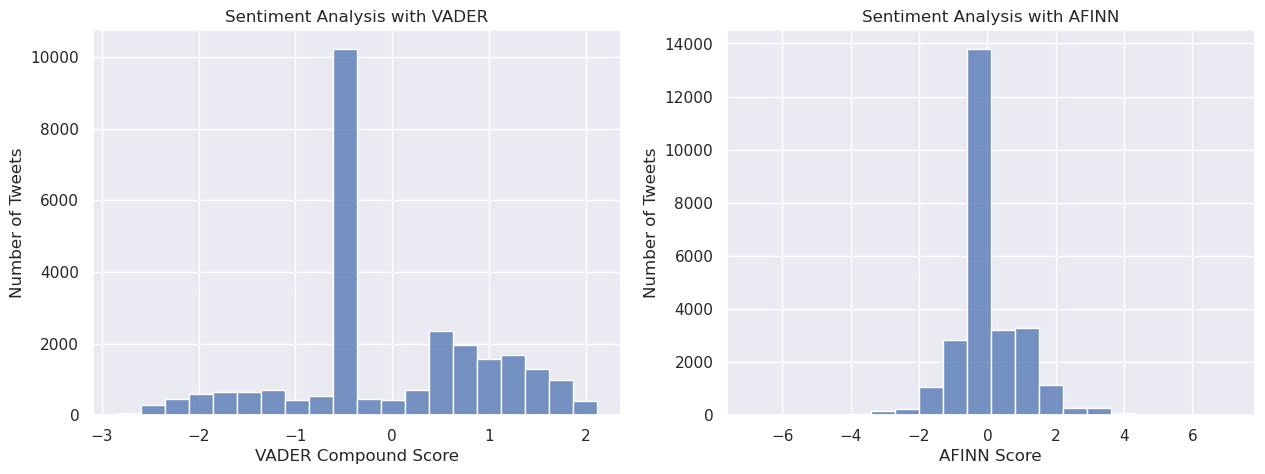

In [233]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.histplot(ts, x="vader", bins=20, ax=ax[0])
sns.histplot(ts, x="afinn", bins=20, ax=ax[1])
ax[0].set_title("Sentiment Analysis with VADER")
ax[0].set_xlabel("VADER Compound Score")
ax[0].set_ylabel("Number of Tweets")

ax[1].set_title("Sentiment Analysis with AFINN")
ax[1].set_xlabel("AFINN Score")
ax[1].set_ylabel("Number of Tweets")

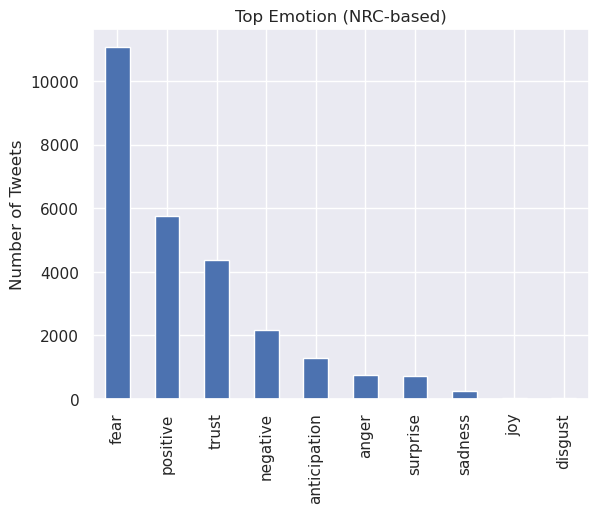

In [235]:
ts["top_emotion"].value_counts().plot(kind="bar")
plt.title("Top Emotion (NRC-based)")
plt.ylabel("Number of Tweets")
plt.show()

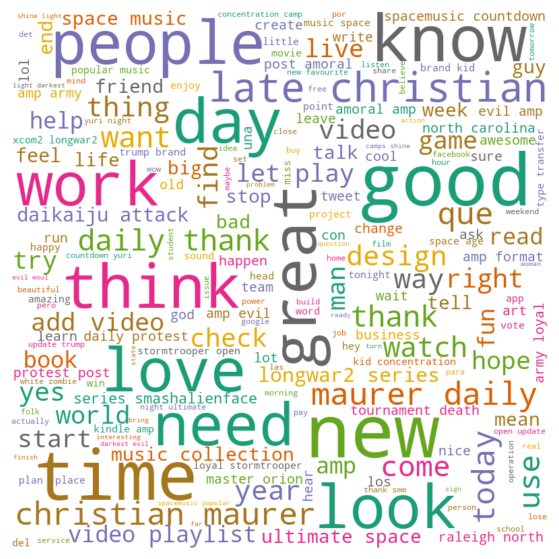

In [238]:
# Combine all tweets into one large text
combined_text = ' '.join(ts['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, random_state=21, normalize_plurals=True,
                      max_font_size=110, background_color="white", colormap="Dark2_r", min_word_length=3).generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

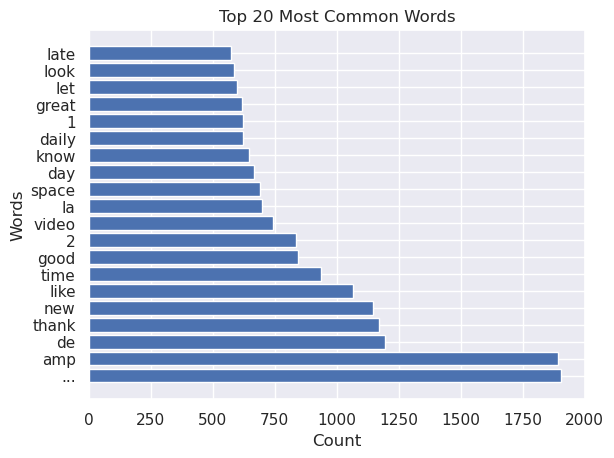

In [251]:
common_words = nltk.FreqDist(combined_text.split()).most_common(20)
# Convert the list of common words into a DataFrame
df_common = pd.DataFrame(common_words, columns=['word', 'count'])

# Create the barh plot
plt.barh(df_common['word'], df_common['count'])
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.show()